<a href="https://colab.research.google.com/github/ReillyOareVT/HydroLearners_Proj/blob/main/clustering/Clustering_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Algorithm Training**
**Author:** Emma Reilly Oare
<br>**Date:** April 25, 2025
<br>**Purpose:** Training of clustering algorithm for EStreams dataset.

In [37]:
# Read in libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    RobustScaler,
    QuantileTransformer,
    FunctionTransformer
)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import umap
import plotly.express as px
import hdbscan

In [ ]:
# Only clone if the repo doesn't already exist
if not os.path.exists('/content/HydroLearners_Proj'):
    !git clone https://github.com/ReillyOareVT/HydroLearners_Proj

# Change directory
BASE_DIR = '/content/HydroLearners_Proj'
os.chdir(BASE_DIR)

# Confirm location
!pwd

/content/HydroLearners_Proj


## Step 1. Read in Data

In [ ]:
# Define path
cluster_path = os.path.join(BASE_DIR, 'clustering', 'processed_data', 'cluster_model_ready_df.xlsx')

# Read in df
cluster_df = pd.read_excel(cluster_path).drop(columns = 'Unnamed: 0')

In [ ]:
# Define path
cluster_path = os.path.join(BASE_DIR, 'mean_regression', 'processed_data', 'mean_reg_model_ready_df.xlsx')

# Read in df
cluster_df = pd.read_excel(cluster_path).drop(columns = ['Unnamed: 0', 'Lithological Dominant Class (Grouped)'])

In [ ]:
# Display df
cluster_df

,Basin ID,Mean Daily Streamflow (mm/day),Ratio of PET/Precipitation,Mean Terrain Slope (Degrees),Mean Aug NDVI,Mean Elevation (m),Mean Root Depth (cm),% Unconsolidated Sediments,Mean % Soil Organic Material,Days/Year with No Flow,Fraction of Snow on Days <0 C,% Metamorphics,Stream Density (1000km/km2),Mean % Clay in Soil,Mean Soil Bulk Density (g/cm3)
0,AT000001,2.824,0.395,24.122,0.645,1874.076,81.571,22.064,1.218,0.000,0.326,23.464,0.151,7.973,1.303
1,AT000002,3.898,0.390,26.095,0.696,1773.178,58.600,0.000,1.820,0.000,0.332,88.549,0.151,15.430,1.502
2,AT000003,0.915,0.411,25.735,0.655,1843.003,51.660,0.070,1.714,0.000,0.337,84.653,0.141,16.883,1.425
3,AT000004,5.079,0.384,27.324,0.657,1890.429,49.412,0.000,1.771,0.000,0.361,59.940,0.095,19.956,1.409
4,AT000005,3.319,0.448,28.647,0.612,1772.902,31.781,0.000,1.836,0.000,0.200,15.582,0.134,20.685,1.384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13501,UAGR0017,0.150,1.354,11.810,0.796,564.291,128.620,0.000,1.198,0.777,0.183,0.000,0.129,47.571,1.246
13502,UAGR0018,0.475,1.270,19.438,0.689,749.565,73.061,0.000,2.340,0.834,0.198,0.000,0.024,30.286,1.066
13503,UAGR0019,0.312,1.494,9.655,0.694,653.127,130.000,0.000,1.178,0.651,0.172,0.000,0.112,47.761,1.251
13504,UAGR0020,0.075,1.856,1.223,0.425,155.662,130.000,0.000,2.094,0.543,0.161,22.366,0.190,32.377,1.303


## Step 2. Model Training & Optimization

In [ ]:
# Specify feature groups by name
quantile_features = [
    'Ratio of PET/Precipitation',
    'Mean Terrain Slope (Degrees)',
    'Mean Aug NDVI',
    'Mean Elevation (m)',
    'Mean % Soil Organic Material',
    'Mean % Clay in Soil',
    'Mean Soil Bulk Density (g/cm3)'
]
sqrt_features = [ 'Fraction of Snow on Days <0 C' ]

# Any other numeric columns to passthrough
pass_features = [
    'Mean Root Depth (cm)',
    '% Unconsolidated Sediments',
    'Days/Year with No Flow',
    '% Metamorphics',
    'Stream Density (1000km/km2)'
]

# Build a preprocessing transformer
preprocessor = ColumnTransformer([
    ('quantile_norm', QuantileTransformer(output_distribution='normal'), quantile_features),
    ('sqrt', FunctionTransformer(np.sqrt, validate=False), sqrt_features),
    ('passthrough', 'passthrough', pass_features)
], remainder='drop')
preprocess_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler())
])

### KMeans

In [ ]:
# Func to identify best k
def evaluate_clusters(df, k_range=range(2, 16)):
    """
    Use a Pipeline to preprocess data and then loop over k to compute metrics.
    Returns lists of SSE, silhouette, Calinski-Harabasz, and Davies-Bouldin scores.
    """
    # Preprocess and scale once
    X_pre = preprocess_pipeline.fit_transform(df)

    sse_list, sil_list, ch_list, db_list = [], [], [], []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_pre)
        labels = km.labels_

        sse_list.append(km.inertia_)
        sil_list.append(silhouette_score(X_pre, labels))
        ch_list.append(calinski_harabasz_score(X_pre, labels))
        db_list.append(davies_bouldin_score(X_pre, labels))

    return sse_list, sil_list, ch_list, db_list

# Define plotting function
def plot_metrics(k_range, sse, sil, ch, db):
    """
    Plot four clustering metrics in a 2x2 grid.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(k_range, sse, marker='.', color = 'maroon')
    axes[0, 0].set_title('SSE (Inertia) vs. Number of Clusters')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Sum of Square Error (SSE)')

    axes[0, 1].plot(k_range, sil, marker='.', color = 'darkorange')
    axes[0, 1].set_title('Silhouette Score vs. Number of Clusters')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Silhouette Score')

    axes[1, 0].plot(k_range, ch, marker='.', color = 'goldenrod')
    axes[1, 0].set_title('Calinski-Harabasz Index vs. Number of Clusters')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Calinski-Harabasz Index')

    axes[1, 1].plot(k_range, db, marker='.', color = 'darkolivegreen')
    axes[1, 1].set_title('Davies-Bouldin Index vs. Number of Clusters')
    axes[1, 1].set_xlabel('Number of Clusters')
    axes[1, 1].set_ylabel('Davies-Bouldin Index')

    plt.tight_layout()
    plt.show()

In [ ]:
# Define algo fitting function
def cluster_and_label(df, n_clusters, n_init=10, max_iter=300, init_method='k-means++'):
    """
    Build a full Pipeline: preprocess + KMeans. Return labels & metrics.
    """
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler()),
        ('kmeans', KMeans(
            n_clusters=n_clusters,
            n_init=n_init,
            max_iter=max_iter,
            init=init_method,
            random_state=42
        ))
    ])

    pipeline.fit(df)
    # Extract scaled array for metric computations
    X_scaled = pipeline.named_steps['scaler'].transform(
        pipeline.named_steps['preprocessor'].transform(df)
    )
    km = pipeline.named_steps['kmeans']
    labels = km.labels_

    sse = km.inertia_
    sil = silhouette_score(X_scaled, labels)
    ch  = calinski_harabasz_score(X_scaled, labels)
    db  = davies_bouldin_score(X_scaled, labels)

    return labels, sse, sil, ch, db

In [ ]:
# ----- Evaluation Plots -------

# Scatter of two first pcs
def plot_pc_scatter(X, labels, chosen_k):
    """
    Scatter plot of the first two principal components.
    """
    plt.figure(figsize=(8, 6))
    pts = plt.scatter(
        X[:, 0], X[:, 1],
        c=labels,
        cmap='tab10',
        s=30,
        alpha=0.7
    )
    plt.legend(
        *pts.legend_elements(),
        title='Cluster',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title(f'PC1 vs PC2 (k={chosen_k})')
    plt.tight_layout()
    plt.show()

# t-SNE !
def plot_tsne_scatter(X, labels, chosen_k):
    """
    t-SNE projection of PCs into 2D, scatter-colored by cluster.
    """
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_tsne[:, 0], X_tsne[:, 1],
        c=labels,
        cmap='tab10',
        s=25,
        alpha=0.7
    )
    plt.title(f't-SNE of PCs (k={chosen_k})')
    plt.xlabel('TSNE-1')
    plt.ylabel('TSNE-2')
    plt.tight_layout()
    plt.show()

# UMAP !
def plot_umap_scatter(X, labels, chosen_k):
    """
    UMAP projection of PCs into 2D, scatter-colored by cluster.
    """
    umap2 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap2.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_umap[:, 0], X_umap[:, 1],
        c=labels,
        cmap='tab10',
        s=25,
        alpha=0.7
    )
    plt.title(f'UMAP of PCs (k={chosen_k})')
    plt.xlabel('UMAP-1')
    plt.ylabel('UMAP-2')
    plt.tight_layout()
    plt.show()

# pairwise plots

def plot_pairwise_pcs(X, labels, chosen_k, pcs=[0, 1, 2]):
    """
    Pairwise scatter of specified PCs colored by cluster.
    """
    df_vis = pd.DataFrame(
        {f'PC{p+1}': X[:, p] for p in pcs}
    )
    df_vis['cluster'] = labels
    sns.pairplot(
        df_vis,
        hue='cluster',
        vars=[f'PC{p+1}' for p in pcs],
        plot_kws={'s': 20, 'alpha': 0.6}
    )
    plt.suptitle(f'Pairwise PCs (k={chosen_k})', y=1.02)
    plt.tight_layout()
    plt.show()

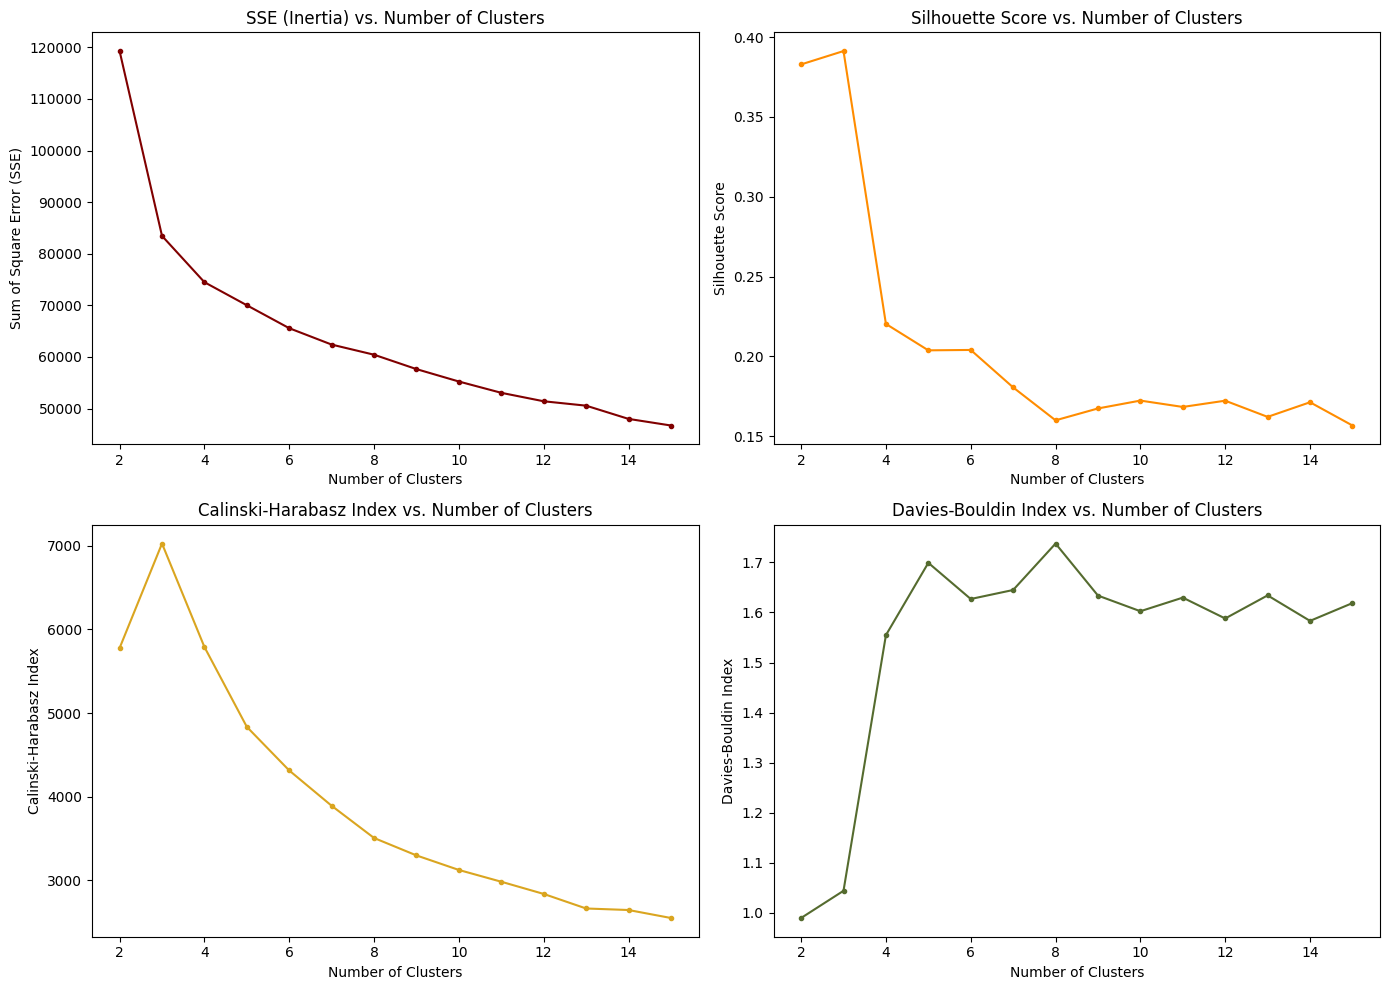

Select number of clusters (k) based on the plots: 8


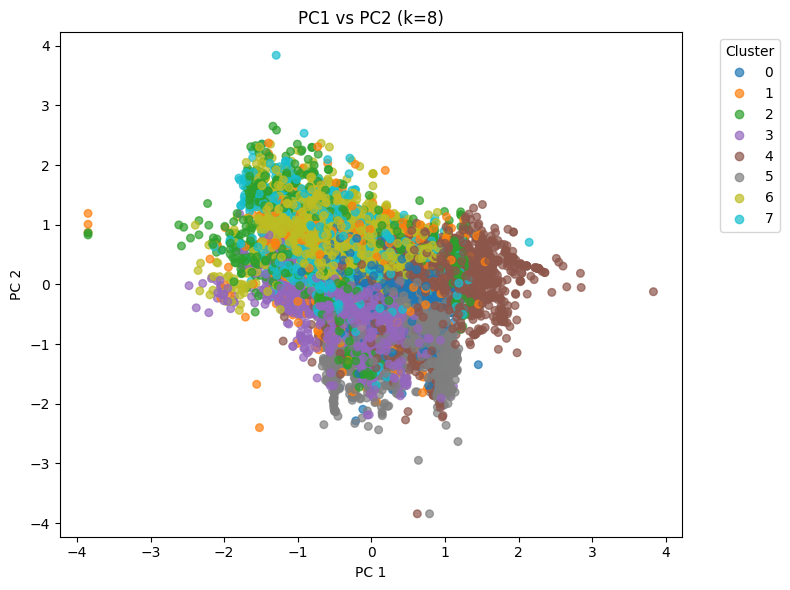

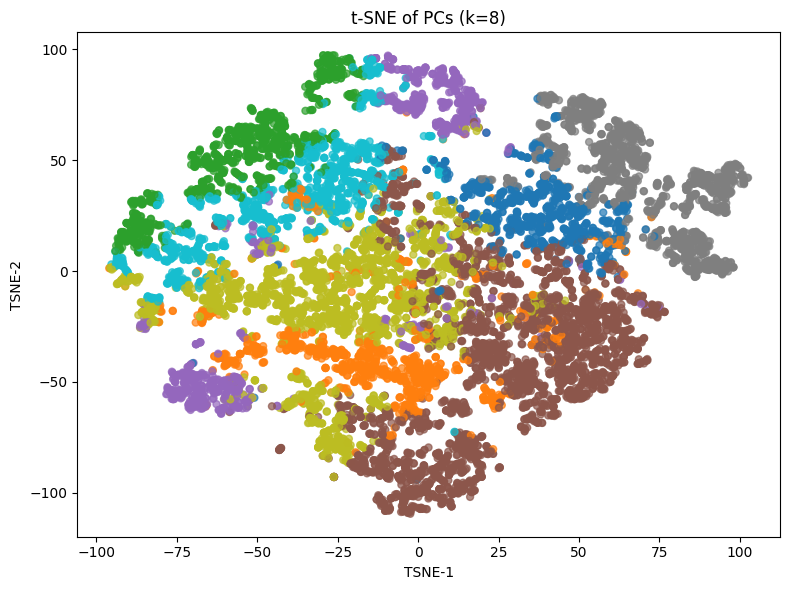

NameError: name 'umap' is not defined

In [33]:
if __name__ == '__main__':
    # Load datasets
    X = cluster_df.drop(columns = 'Basin ID')

    # Compute metrics across k=2..15
    k_values = list(range(2, 16))
    sse, sil, ch, db = evaluate_clusters(X, k_values)

    # Plot all four metrics
    plot_metrics(k_values, sse, sil, ch, db)

    # Ask user to choose k
    chosen_k = int(input('Select number of clusters (k) based on the plots: '))

    # Final clustering with user-specified hyperparameters
    # You can adjust n_init and init_method here if desired
    labels, final_sse, final_sil, final_ch, final_db = cluster_and_label(
        X,
        n_clusters=chosen_k,
        n_init=50,
        max_iter = 500,
        init_method='k-means++'
    )
    cluster_df['cluster'] = labels

    # Visualize final cluster assignments
    plot_pc_scatter(preprocess_pipeline.transform(X), labels, chosen_k)
    plot_tsne_scatter(preprocess_pipeline.transform(X), labels, chosen_k)
    plot_umap_scatter(preprocess_pipeline.transform(X), labels, chosen_k)
    plot_pairwise_pcs(preprocess_pipeline.transform(X), labels, chosen_k)

    # Display and save results
    print(f"Chosen k = {chosen_k}")
    print(f"SSE: {final_sse:.2f}")
    print(f"Silhouette Score: {final_sil:.4f}")
    print(f"Calinski-Harabasz Index: {final_ch:.2f}")
    print(f"Davies-Bouldin Index: {final_db:.4f}")

### HDBSCAN

In [44]:
def evaluate_hdbscan_grid(
    df,
    min_cluster_sizes=[20, 50, 100, 200],
    min_samples_list=[5, 10, 20, 50],
    preprocess_pipeline=None
):
    """
    Sweep over HDBSCAN parameters and return a DataFrame
    with silhouette, n_clusters, and noise_fraction for each combo.
    """
    # 1) Preprocess once
    X = preprocess_pipeline.fit_transform(df)

    records = []
    for mcs in min_cluster_sizes:
        for ms in min_samples_list:
            cl = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                cluster_selection_method='eom'
            )
            labels = cl.fit_predict(X)
            # mask out noise
            mask = labels >= 0
            n_clusters = len(set(labels[mask]))
            noise_frac = np.mean(labels == -1)

            if n_clusters > 1:
                sil = silhouette_score(X[mask], labels[mask])
            else:
                sil = np.nan

            records.append({
                'min_cluster_size': mcs,
                'min_samples':       ms,
                'silhouette':        sil,
                'n_clusters':        n_clusters,
                'noise_fraction':    noise_frac
            })

    return pd.DataFrame(records)

In [42]:
def plot_hdbscan_heatmaps(df_res):
    """
    Given the DataFrame from evaluate_hdbscan_grid, make three heatmaps.
    """
    pivot_sil = df_res.pivot(
        index='min_cluster_size',
        columns='min_samples',
        values='silhouette'
    )
    pivot_nc = df_res.pivot(
        index='min_cluster_size',
        columns='min_samples',
        values='n_clusters'
    )
    pivot_nf = df_res.pivot(
        index='min_cluster_size',
        columns='min_samples',
        values='noise_fraction'
    )

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    sns.heatmap(pivot_sil, annot=True, fmt='.2f', ax=axes[0])
    axes[0].set_title('Silhouette score')
    sns.heatmap(pivot_nc, annot=True, fmt='d', cmap='mako', ax=axes[1])
    axes[1].set_title('# clusters')
    sns.heatmap(pivot_nf, annot=True, fmt='.2f', cmap='rocket', ax=axes[2])
    axes[2].set_title('Noise fraction')

    for ax in axes:
        ax.set_xlabel('min_samples')
        ax.set_ylabel('min_cluster_size')

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

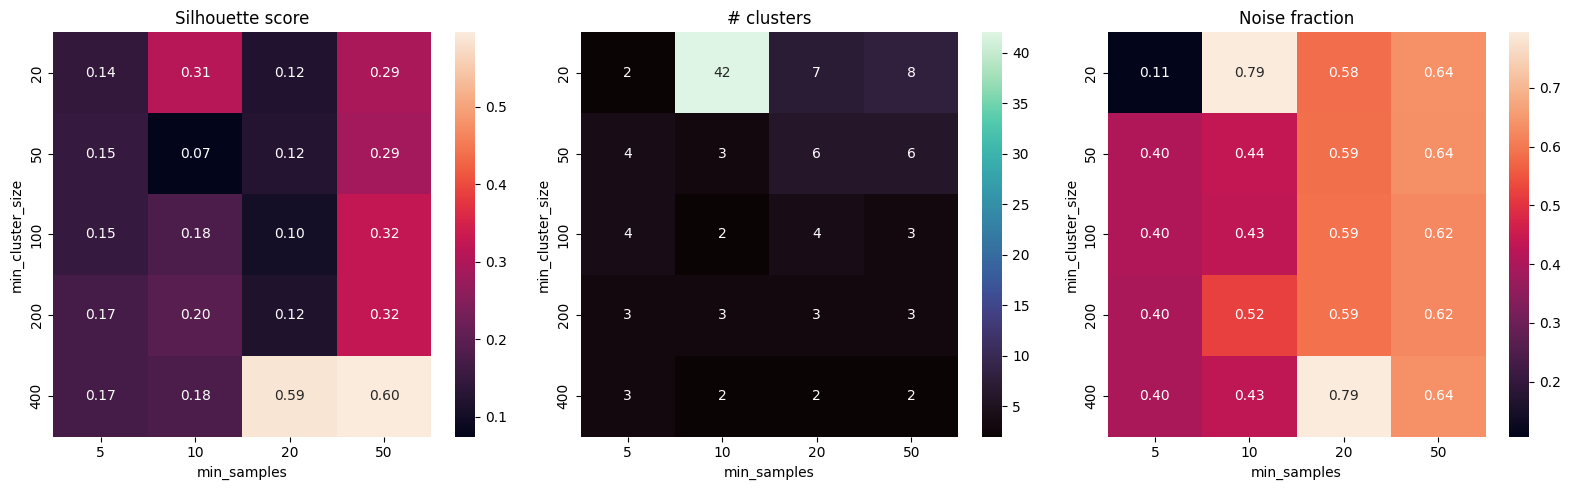

NameError: name 'df_full' is not defined

In [45]:
# 1) Sweep grid
results = evaluate_hdbscan_grid(
    X,
    min_cluster_sizes=[20,50,100,200,400],
    min_samples_list=[5,10,20,50],
    preprocess_pipeline=preprocess_pipeline
)

# 2) Visualize
plot_hdbscan_heatmaps(results)

# 3) Pick your “sweet spot” in the heatmaps:
#    e.g. a cell with high silhouette, a moderate cluster count, and low noise.

# 4) Fit final HDBSCAN
final_mcs = 100
final_ms  = 10
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=final_mcs,
    min_samples=final_ms,
    cluster_selection_method='eom'
)
X_pre = preprocess_pipeline.transform(df_full)
labels = clusterer.fit_predict(X_pre)
df_full['cluster_hdbscan'] = labels

## Step 3. Cluster Visualization

In [49]:
# Define path
info_path = os.path.join(BASE_DIR, 'raw_data', 'estreams_gauging_stations.csv')
# Read in df
info_df = pd.read_csv(info_path)
info_df = info_df[['basin_id', 'lon','lat']].rename(columns = {'basin_id':'Basin ID'})

In [50]:
# Merge two dfs
cluster_loc_df = cluster_df.merge(info_df,
                                  how = 'left',
                                  on = 'Basin ID')
cluster_loc_df

,Basin ID,Mean Daily Streamflow (mm/day),Ratio of PET/Precipitation,Mean Terrain Slope (Degrees),Mean Aug NDVI,Mean Elevation (m),Mean Root Depth (cm),% Unconsolidated Sediments,Mean % Soil Organic Material,Days/Year with No Flow,Fraction of Snow on Days <0 C,% Metamorphics,Stream Density (1000km/km2),Mean % Clay in Soil,Mean Soil Bulk Density (g/cm3),cluster,cluster_hdbscan,lon,lat
0,AT000001,2.824,0.395,24.122,0.645,1874.076,81.571,22.064,1.218,0.000,0.326,23.464,0.151,7.973,1.303,7,2,9.534835,47.273748
1,AT000002,3.898,0.390,26.095,0.696,1773.178,58.600,0.000,1.820,0.000,0.332,88.549,0.151,15.430,1.502,2,2,9.913677,47.080301
2,AT000003,0.915,0.411,25.735,0.655,1843.003,51.660,0.070,1.714,0.000,0.337,84.653,0.141,16.883,1.425,2,2,9.847765,47.132821
3,AT000004,5.079,0.384,27.324,0.657,1890.429,49.412,0.000,1.771,0.000,0.361,59.940,0.095,19.956,1.409,7,-1,10.061843,47.128994
4,AT000005,3.319,0.448,28.647,0.612,1772.902,31.781,0.000,1.836,0.000,0.200,15.582,0.134,20.685,1.384,6,-1,9.802668,47.150770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13501,UAGR0017,0.150,1.354,11.810,0.796,564.291,128.620,0.000,1.198,0.777,0.183,0.000,0.129,47.571,1.246,6,-1,33.900000,44.683333
13502,UAGR0018,0.475,1.270,19.438,0.689,749.565,73.061,0.000,2.340,0.834,0.198,0.000,0.024,30.286,1.066,1,-1,34.166667,44.500000
13503,UAGR0019,0.312,1.494,9.655,0.694,653.127,130.000,0.000,1.178,0.651,0.172,0.000,0.112,47.761,1.251,4,-1,34.200000,44.883333
13504,UAGR0020,0.075,1.856,1.223,0.425,155.662,130.000,0.000,2.094,0.543,0.161,22.366,0.190,32.377,1.303,4,-1,35.705833,47.251389


In [52]:
import plotly.express as px

def plot_cluster_map(df,
                     lat_col='lat',
                     lon_col='lon',
                     cluster_col='cluster_hdbscan',
                     center_lat=54.0,
                     center_lon=15.0,
                     zoom=2):
    """
    Plot a Mapbox scatter of clusters over Europe.
    - df:          your DataFrame (cluster_loc_df)
    - lat_col:     name of the latitude column
    - lon_col:     name of the longitude column
    - cluster_col: name of the cluster label column
    - center_lat:  map center latitude (Europe ≈ 54°N)
    - center_lon:  map center longitude (Europe ≈ 15°E)
    - zoom:        initial zoom level (4–6 is continental)
    """
    fig = px.scatter_mapbox(
        df,
        lat=lat_col,
        lon=lon_col,
        color=cluster_col,
        hover_data=[cluster_col],
        zoom=zoom,
        center={'lat': center_lat, 'lon': center_lon},
        mapbox_style='carto-positron',  # no token required
        title='Stream Clusters Across Europe'
    )
    fig.update_layout(margin={'l':0,'r':0,'t':30,'b':0})
    fig.show()

# --- usage ---
# Assuming you’ve already got your DataFrame:
# cluster_loc_df = pd.read_csv('labeled_dataset.csv')
plot_cluster_map(cluster_loc_df)
